In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import xml.etree.ElementTree as et
import os
from pathlib import Path
import glob

In [5]:
# df = pd.read_xml('570-ws-training.xml')

In [6]:
from pandas.core.construction import is_empty_data
import xml.etree.ElementTree as ET
tree = ET.parse('/content/drive/MyDrive/dataxml/570-ws-training.xml')
root = tree.getroot()
taglist = []
for child in root:
    #print(child.tag, child.attrib)
    taglist.append(child.tag)
#print(taglist)
dict_attr = dict()
for i in range(len(root)):
      dict_list = dict()
      try:
          key_list = root[i][0].keys()
      except (IndexError, ValueError):
          key_list = ['empty']
          dict_attr[taglist[i]]={'empty_ts': ['07-12-2021 07:13:07']}

      #print(taglist[i])
      for attr in key_list:
         dict_list[taglist[i]+'_'+attr] = []
      for event in root[i]:
         for attr in key_list:
            dict_list[taglist[i]+'_'+attr].append(event.attrib[attr])
#            print(event.tag, event.attrib)   
#            dict_list.append(event.attrib)
         dict_attr[taglist[i]] =  dict_list
print("Tag, num_items")
for i in range(len(root)):
    print(i, taglist[i], len(dict_attr[taglist[i]]))

Tag, num_items
0 glucose_level 2
1 finger_stick 2
2 basal 2
3 temp_basal 3
4 bolus 5
5 meal 3
6 sleep 3
7 work 3
8 stressors 1
9 hypo_event 1
10 illness 1
11 exercise 5
12 basis_heart_rate 2
13 basis_gsr 2
14 basis_skin_temperature 2
15 basis_air_temperature 2
16 basis_steps 2
17 basis_sleep 4


In [7]:
path = '/content/drive/MyDrive/dataxml/570-ws-training.xml'
df = pd.read_xml(path, xpath=".//event")


In [8]:
# ดึงข้อมูลแต่ละ taglist ไปเป็น dataframe
for child in root:
  name = child.tag
  try:
    locals()['{0}'.format(name)] = pd.read_xml(path, xpath = "./"+name+"/event")
    print(name)
  except (IndexError, ValueError):
    locals()['{0}'.format(name)] = pd.DataFrame({'empty_ts': ['07-12-2021 07:13:07']})
    print(name)


glucose_level
finger_stick
basal
temp_basal
bolus
meal
sleep
work
stressors
hypo_event
illness
exercise
basis_heart_rate
basis_gsr
basis_skin_temperature
basis_air_temperature
basis_steps
basis_sleep


## **Lastest Data**
# glucose_level


In [9]:
lastest_glu = glucose_level
lastest_glu['ts'] = pd.to_datetime(lastest_glu.ts, format = '%d-%m-%Y %H:%M:%S')
lastest_glu.sort_values(by = ['ts'], ascending = False, inplace = True) 

lastest_glu = lastest_glu.assign(time = pd.cut(lastest_glu.ts.dt.hour,[0,6,12,18,24], labels=['night', 'morning', 'afternoon', 'evening'], right=False, include_lowest=True))
lastest_glu['ts'] = pd.to_datetime(lastest_glu['ts'], format = '%d-%m-%Y %H:%M:%S').dt.strftime('%d-%m-%Y %H:%M:%S')

# glucose_level['date'] = pd.to_datetime(glucose_level.ts, format = '%d-%m-%Y %H:%M:%S').dt.strftime('%d-%m-%Y')
# glucose_level['time'] = pd.to_datetime(glucose_level.ts, format = '%d-%m-%Y %H:%M:%S').dt.strftime('%H:%M:%S')

print(lastest_glu.iloc[0])

ts       16-01-2022 23:59:00
value                    128
time                 evening
Name: 10981, dtype: object


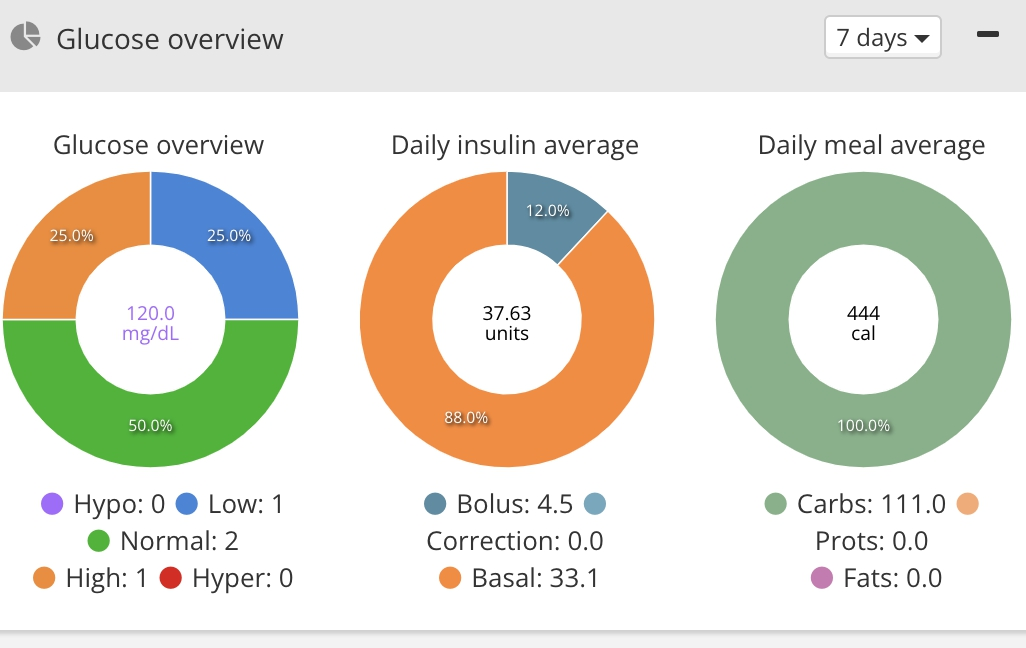

## **Glucose overview**

In [10]:
#ต่อdataframe glucose_level กับ finger_stick
glu_level = pd.concat([glucose_level, finger_stick],ignore_index=True)
#แปลง ค่าระดับน้ำตาล เป็น Hypo', 'Low', 'normal', 'High', 'Hyper'
glu_level['lavel'] = pd.cut(glu_level['value'], bins=[0,54,90,120,220,500], labels=['Hypo', 'Low', 'normal', 'High', 'Hyper'])

#group Hypo', 'Low', 'normal', 'High', 'Hyper' ว่าแต่ละอันมีกี่ rows
category_glu = glu_level.groupby(['lavel']).agg({'value': 'count'})

#คิดเปอร์เซ็นของแต่ละ group
percentage_lavel_glu = glu_level.lavel.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'


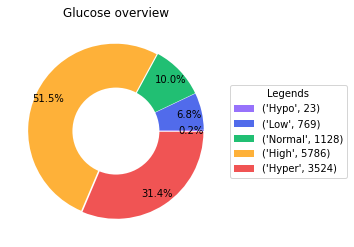

In [11]:
import matplotlib.pyplot as plt


# Setting size in Chart based on
# given values
# sizes = [sum.value.Hypo, sum.value.Low, sum.value.normal, sum.value.High, sum.value.Hyper]
sizes = [category_glu.value.Hypo, category_glu.value.Low, category_glu.value.normal, category_glu.value.High, category_glu.value.Hyper]
Hypo = "Hypo", category_glu.value.Hypo
Low = "Low", category_glu.value.Low
Normal = "Normal", category_glu.value.normal
High = "High", category_glu.value.High
Hyper = "Hyper", category_glu.value.Hyper

# Setting labels for items in Chart
labels = [Hypo, Low, Normal, High, Hyper]

# colors
colors = ['#9772FB', '#516BEB', '#21BF73', '#FEB139','#F05454']

# explosion
explode = (0.01, 0.01, 0.01, 0.01, 0.01)

# Pie Chart
plt.pie(sizes, colors=colors,
		autopct='%1.1f%%', pctdistance=0.85,
		explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('Glucose overview')

# Add Legends
plt.legend(labels,   loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), title="Legends")


# Displaying Chart
plt.show()


## **Daily insulin average**
bolus คืออินซูลินชนิดออกฤทธิ์เร็ว เช่น ฉีดตอนรับประทานอาหารหรือฉีดเพื่อแก้ไข <br>
basal *คืออินซูลินชนิดออกฤทธิ์ช้า* หรือที่เรียกว่าออกฤทธิ์นาน

In [12]:
Date = "16-01-2022"

In [13]:
basal['ts']   = pd.to_datetime(basal.ts, format = '%d-%m-%Y %H:%M:%S')
basal['date'] = basal['ts'].dt.date
basal['ts']   = pd.to_datetime(basal['ts'], format = '%d-%m-%Y %H:%M:%S').dt.strftime('%d-%m-%Y %H:%M:%S')
basal['date'] = pd.to_datetime(basal['date'], format = '%Y-%m-%d').dt.strftime('%d-%m-%Y')
basal_date    = basal.loc[basal['date'] == Date]
mean_basal_daily = basal_date.mean()
mean_basal_daily

<ipython-input-13-bd3634450fea>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_basal_daily = basal_date.mean()


value    1.066
dtype: float64

In [14]:
bolus = bolus.rename(columns = {'ts_begin':'ts','dose':'value'})
bolus_df = bolus[["ts", "value"]]

bolus_df['ts']   = pd.to_datetime(bolus_df.ts, format = '%d-%m-%Y %H:%M:%S')
bolus_df['date'] = bolus_df['ts'].dt.date
bolus_df['ts']   = pd.to_datetime(bolus_df['ts'], format = '%d-%m-%Y %H:%M:%S').dt.strftime('%d-%m-%Y %H:%M:%S')
bolus_df['date'] = pd.to_datetime(bolus_df['date'], format = '%Y-%m-%d').dt.strftime('%d-%m-%Y')
bolus_date       = bolus_df[bolus_df['date']  == Date]
mean_bolus_daily = bolus_date.mean()
mean_bolus_daily

<ipython-input-14-ffdf92b35fa9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bolus_df['ts']   = pd.to_datetime(bolus_df.ts, format = '%d-%m-%Y %H:%M:%S')
<ipython-input-14-ffdf92b35fa9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bolus_df['date'] = bolus_df['ts'].dt.date
<ipython-input-14-ffdf92b35fa9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

value    6.825
dtype: float64

In [15]:
#ผลรวม dose
sum_dose_basal = basal_date.value.sum()
sum_dose_bolus = bolus_date.value.sum()
sum_dose = sum_dose_basal+sum_dose_bolus
sum_dose = round(sum_dose, 2)
sum_dose_str = str(sum_dose) +'\n units'

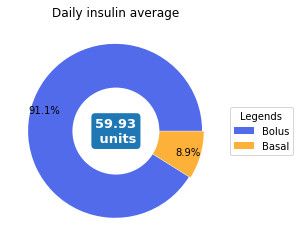

In [16]:

# Setting size in Chart based on
# given values
sizes = [sum_dose_bolus , sum_dose_basal]

# Setting labels for items in Chart
labels = ['Bolus', 'Basal']

# colors
colors = ['#516BEB', '#FEB139']

#explosion
explode = (0.01, 0.01)

# Pie Chart
plt.pie(sizes, colors=colors,
		autopct='%1.1f%%', pctdistance=0.85,
		explode=explode)

# outside = ax.pie(sizes, radius=1, pctdistance=1-width/2,
#                  labels=labels,**kwargs)[0]

# plt.text(0.4, 0.4, sum_dose_str , va = 'center', ha = 'center', backgroundcolor = 'white')

# draw circle
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('Daily insulin average')

kwargs = dict(size=13, color='white', va='center', fontweight='bold')
plt.text(0, 0, sum_dose_str, ha='center',
        bbox=dict(boxstyle='round', edgecolor='none'),
        **kwargs)

# plt.text(0, 0, sum_dose_str, ha='center',
#         bbox=dict(boxstyle='round', facecolor='#9772FB', edgecolor='none'),
#         **kwargs)
# Add Legends
plt.legend(labels,   loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), title="Legends")



# Displaying Chart
plt.show()


## **Daily meal average**

In [17]:
meal

meal_df = meal.rename(columns = {'type':'cate'})
# meal_df = bolus[["cate", "carbs"]]
meal_df

,ts,cate,carbs
0,07-12-2021 18:28:00,Dinner,65
1,07-12-2021 21:33:00,Snack,5
2,08-12-2021 06:14:00,Breakfast,97
3,08-12-2021 12:04:00,Lunch,120
4,08-12-2021 16:50:00,Snack,38
...,...,...,...
131,15-01-2022 21:03:00,Dinner,130
132,16-01-2022 08:28:00,Breakfast,75
133,16-01-2022 13:46:00,Snack,90
134,16-01-2022 18:47:00,Snack,60


In [18]:
meal_df['ts']   = pd.to_datetime(meal_df.ts, format = '%d-%m-%Y %H:%M:%S')
meal_df['date'] = meal_df['ts'].dt.date
meal_df['ts']   = pd.to_datetime(meal_df['ts'], format = '%d-%m-%Y %H:%M:%S').dt.strftime('%d-%m-%Y %H:%M:%S')
meal_df['date'] = pd.to_datetime(meal_df['date'], format = '%Y-%m-%d').dt.strftime('%d-%m-%Y')
meal_date    = meal_df.loc[meal_df['date'] == Date]
mean_meal_daily = meal_date.mean()
mean_meal_daily

<ipython-input-18-6981b0c70c51>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_meal_daily = meal_date.mean()


carbs    93.75
dtype: float64

In [19]:
carb_sum = meal_date.carbs.sum()
carb_sum = round(carb_sum)
carb_sum = str(carb_sum) +'\n cal'

In [20]:
carb_sum

'375\n cal'

In [21]:
meal_date = meal_date.groupby(['cate']).agg({'carbs': 'mean'})
meal_date.reset_index(inplace=True)


# meal_date

In [22]:
meal_date

,cate,carbs
0,Breakfast,75.0
1,Dinner,150.0
2,Snack,75.0


In [23]:
name_crabs = meal_date.carbs.to_numpy()
name_cate = meal_date.cate.to_numpy()

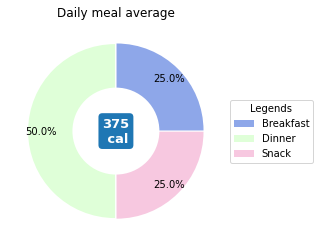

In [24]:

# Setting size in Chart based on
# given values
sizes = name_crabs

# Setting labels for items in Chart
labels = name_cate

# colors
colors = ['#8EA7E9', '#DFFFD8', '#F7C8E0', '#95BDFF','#FFC93C']


#explosion
explode = [ 0.01 for i in labels ]




# Pie Chart
plt.pie(sizes, colors=colors,
		autopct='%1.1f%%', pctdistance=0.85,
		explode=explode)

# outside = ax.pie(sizes, radius=1, pctdistance=1-width/2,
#                  labels=labels,**kwargs)[0]

# plt.text(0.4, 0.4, sum_dose_str , va = 'center', ha = 'center', backgroundcolor = 'white')

# draw circle
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('Daily meal average')

kwargs = dict(size=13, color='white', va='center', fontweight='bold')
plt.text(0, 0, carb_sum, ha='center',
        bbox=dict(boxstyle='round', edgecolor='none'),
        **kwargs)

# plt.text(0, 0, sum_dose_str, ha='center',
#         bbox=dict(boxstyle='round', facecolor='#9772FB', edgecolor='none'),
#         **kwargs)
# Add Legends
plt.legend(labels,   loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), title="Legends")



# Displaying Chart
plt.show()

In [32]:
import base64
from io import BytesIO

from flask import Flask
from matplotlib.figure import Figure

app = Flask(__name__)


@app.route("/")
def hello():
    # Generate the figure **without using pyplot**.
    fig = Figure()
    ax = fig.subplots()
    ax.plot([1, 2])
    # Save it to a temporary buffer.
    buf = BytesIO()
    fig.savefig(buf, format="png")
    # Embed the result in the html output.
    data = base64.b64encode(buf.getbuffer()).decode("ascii")
    return f"<img src='data:image/png;base64,{data}'/>"

In [42]:
pip install dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 17.1 MB/s eta 0:00:00


In [43]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
import seaborn as sns
app = dash.Dash()
df = sns.load_dataset('titanic')
fig = px.scatter(
df,
x="fare",
y="age",
size="pclass",
color="alive",
hover_name="embark_town",
log_x=True,
size_max=60
)
app.layout = html.Div(children = [
html.H1(children='Titanic Dashboard'),
dcc.Graph(id="fare_vs_age", figure=fig)])

if __name__ == "__main__":
    app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/



INFO:__main__:Dash is running on http://127.0.0.1:8050/

2023-03-03 06:51:05.201 Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: on


In [44]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import seaborn as sns
app = dash.Dash()
df = sns.load_dataset('titanic')
fig = px.scatter(
df,
x="fare",
y="age",
size="pclass",
color="alive",
hover_name="embark_town",
log_x=True,
size_max=60
)
app.layout = html.Div(children = [
html.H1(children='Titanic Dashboard'),
dcc.Graph(id="fare_vs_age", figure=fig),
#Add interactive callback here
html.H4("Change the value in the text box to see callbacks in action"),
html.Div([
"Input: ",
dcc.Input(id='my-input', value='initial value', type='text')
]),
html.Br(),
html.Div(id='my-output'),
])
@app.callback(
Output(component_id='my-output', component_property='children'),
Input(component_id='my-input', component_property='value')
)
def update_output_div(input_value):
    return f'Output: {input_value}'
if __name__ == "__main__":
   app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/



INFO:__main__:Dash is running on http://127.0.0.1:8050/

2023-03-03 06:52:05.545 Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: on
